Выполнил: Кагарманов Эрик  
Data scientist  
mail: kagarmanov.science@gmail.com  
telegram: https://t.me/erikkagarmanov  

# Описание задания

Рассматривается электрохимический сенсор `SO2`, основными параметрами которого являются значения напряжений на рабочем и вспомогательных электродах `SO2op1` и `SO2op2`. Помимо основных параметров, на сенсор могут вилять температура и концентрация кросс-газа `NO2`.

В распоряжении два файла:
- Файл с результатами лабораторной калибровки сенсора - `G2.csv`.
- Файл с показаниями сенсоров в полевых условиях - `test.csv`

Необходимо предложить модель (Некоторая модель, описывающая концентрацию `SO2` в атмосфере и учитывающая влияние на сенсор внешних факторов) и построить прогноз модели на данных, собранных в полевых условиях.

Задание по пунктам:

1. Прочитать файлы `G2.csv` и `test.csv`.
2. Предложить модель (За исключением мультипараметрической линейной регрессии) описывающую зависимость концентрации газа `SO2` от значений `SO2op1`, `SO2op2`, `T` и кросс-газа `NO2`.
4. Сравнить прогноз полученной модели с мультипараметрической линейной регрессией.
5. Построить графики прогнозов моделей от времени на обучающей и тестовых выборках.
6. Интерпретировать полученные результаты.
6. Сделать выводы.

----------
* Дополнительные вопросы:
    - Оценить погрешности предложенной модели и линейной регрессии?
    - Чем отличается предложенная модель от линейной регрессии?
    - Что можно сказать об обучающей и тестовой выборках?


# Imports

In [1]:
# %pip install -U dataprep --user

In [2]:
# работа с данными
import pandas as pd
import numpy as np

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# eda
from dataprep import eda

# нормализация данных
from sklearn.preprocessing import MinMaxScaler

# статистические тесты
from scipy.stats import ks_2samp

# метрики и валидация
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

# машинное обучение
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# от предупреждений
import warnings
warnings.simplefilter("ignore")

# Загрузка и общий обзор данных

In [3]:
train = pd.read_csv('G2.csv.xls')

In [4]:
train.head()

,date,SO2op1,SO2op2,T,SO2,NO2
0,2022-06-22 09:06:24,389.807,345.705,20.844,448.0,0.0
1,2022-06-22 09:06:54,390.261,345.983,20.875,448.0,0.0
2,2022-06-22 09:07:24,390.261,345.983,20.844,448.0,0.0
3,2022-06-22 09:07:54,389.708,345.844,20.875,448.0,0.0
4,2022-06-22 09:08:24,389.708,345.844,20.875,448.0,0.0


In [5]:
test = pd.read_csv('test.csv.xls')

In [6]:
test.head()

,date,SO2op1,SO2op2,T,NO2
0,2022-09-12 08:00:00,348.10,344.89,9.845,43.446494
1,2022-09-12 08:05:00,348.20,344.58,9.845,45.494829
2,2022-09-12 08:10:00,348.06,344.53,9.910,45.498952
3,2022-09-12 08:15:00,348.06,344.61,9.970,42.848022
4,2022-09-12 08:20:00,348.30,344.83,10.030,42.880397


In [7]:
# объеденим выборки отметив тестовую часть 
train['test'] = 0
test['test'] = 1
df = pd.concat([train, test]).reset_index(drop = True)

In [8]:
# преобразуем даты
df['date'] = df['date'].apply(pd.to_datetime)

In [9]:
# разделим признаки и таргет на даты, числовые признаки и таргет
date_cols = ['date']
num_cols = ['SO2op1', 'SO2op2', 'T','NO2']
target = ['SO2']

# объеденим признаки в одной переменной
features = date_cols + num_cols

# EDA

Проведем общий анализ выборки и сравним обучающую и тренировочную выборки.
Проверим количество пропусков, долю уникальных значений, описательные статистики

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1020 non-null   datetime64[ns]
 1   SO2op1  1020 non-null   float64       
 2   SO2op2  1020 non-null   float64       
 3   T       1020 non-null   float64       
 4   SO2     156 non-null    float64       
 5   NO2     1020 non-null   float64       
 6   test    1020 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 55.9 KB


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    156 non-null    object 
 1   SO2op1  156 non-null    float64
 2   SO2op2  156 non-null    float64
 3   T       156 non-null    float64
 4   SO2     156 non-null    float64
 5   NO2     156 non-null    float64
 6   test    156 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 8.7+ KB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    864 non-null    object 
 1   SO2op1  864 non-null    float64
 2   SO2op2  864 non-null    float64
 3   T       864 non-null    float64
 4   NO2     864 non-null    float64
 5   test    864 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 40.6+ KB


In [13]:
df.isna().sum().sort_values(ascending = False) / df.shape[0]

SO2       0.847059
date      0.000000
SO2op1    0.000000
SO2op2    0.000000
T         0.000000
NO2       0.000000
test      0.000000
dtype: float64

In [14]:
train.isna().sum().sort_values(ascending = False) / train.shape[0]

date      0.0
SO2op1    0.0
SO2op2    0.0
T         0.0
SO2       0.0
NO2       0.0
test      0.0
dtype: float64

In [15]:
test.isna().sum().sort_values(ascending = False) / test.shape[0]

date      0.0
SO2op1    0.0
SO2op2    0.0
T         0.0
NO2       0.0
test      0.0
dtype: float64

In [16]:
df.nunique().sort_values(ascending = False) / df.shape[0]

date      1.000000
NO2       0.849020
SO2op1    0.314706
SO2op2    0.233333
T         0.229412
SO2       0.002941
test      0.001961
dtype: float64

In [17]:
train.nunique().sort_values(ascending = False) / train.shape[0]

date      1.000000
SO2op2    0.519231
SO2op1    0.512821
T         0.044872
SO2       0.019231
NO2       0.019231
test      0.006410
dtype: float64

In [18]:
test.nunique().sort_values(ascending = False) / test.shape[0]

date      1.000000
NO2       0.998843
SO2op1    0.278935
T         0.262731
SO2op2    0.195602
test      0.001157
dtype: float64

In [19]:
df.describe()

,SO2op1,SO2op2,T,SO2,NO2,test
count,1020.000000,1020.000000,1020.000000,156.000000,1020.000000,1020.000000
mean,345.330746,345.199254,12.907215,89.025641,91.323876,0.847059
std,23.994336,0.381978,3.828880,158.247742,200.387792,0.360107
min,234.286000,343.040000,9.000000,0.000000,0.000000,0.000000
25%,348.740000,344.960000,10.302500,0.000000,38.127163,1.000000
50%,349.120000,345.200000,11.627500,0.000000,44.419940,1.000000
75%,349.602500,345.450000,14.530000,224.000000,53.314502,1.000000
max,390.261000,346.267000,21.187500,448.000000,1088.000000,1.000000


In [20]:
train.describe()

,SO2op1,SO2op2,T,SO2,NO2,test
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.0
mean,324.248212,345.540891,20.936311,89.025641,334.769231,0.0
std,57.052503,0.351442,0.136996,158.247742,438.963381,0.0
min,234.286000,344.685000,20.781500,0.000000,0.000000,0.0
25%,284.888000,345.245750,20.844000,0.000000,0.000000,0.0
50%,353.593000,345.592500,20.875000,0.000000,0.000000,0.0
75%,376.545750,345.815000,21.125000,224.000000,544.000000,0.0
max,390.261000,346.267000,21.187500,448.000000,1088.000000,0.0


In [21]:
test.describe()

,SO2op1,SO2op2,T,NO2,test
count,864.000000,864.000000,864.000000,864.000000,864.0
mean,349.137315,345.137569,11.457517,47.368465,1.0
std,0.576363,0.353824,1.884068,12.585284,0.0
min,347.100000,343.040000,9.000000,14.723622,1.0
25%,348.780000,344.920000,9.902500,39.500451,1.0
50%,349.100000,345.160000,11.080000,44.851663,1.0
75%,349.460000,345.370000,12.352500,52.257360,1.0
max,352.560000,346.080000,16.030000,87.887305,1.0


Визуально оценим распределение признаков. Посмотрим на распределение в тренировочной и тестововой выборках.

array([[<AxesSubplot:title={'center':'SO2'}>]], dtype=object)

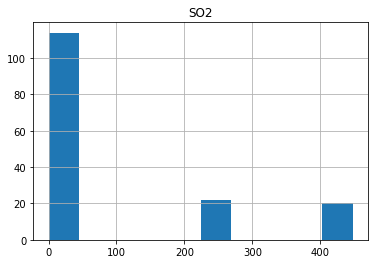

In [22]:
df[target].hist()

In [23]:
# визуализация признаков для тренировочной выборки
report = eda.create_report(df[df['test'] == 0])
report.show_browser() # вывести отчёт в браузере
# report

  0%|          | 0/819 [00:00<?, ?it/s]

In [24]:
# визуализация признаков для тестовой выборки
report = eda.create_report(df[df['test'] == 1])
report.show_browser() # вывести отчёт в браузере
# report

  0%|          | 0/1028 [00:00<?, ?it/s]

Визуализируем распределение признаков в тренировочной и тестовой выборках.

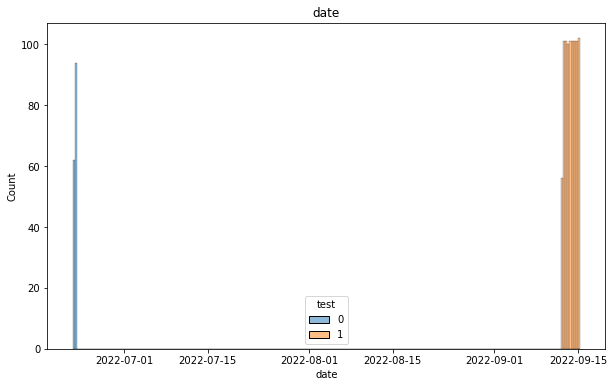

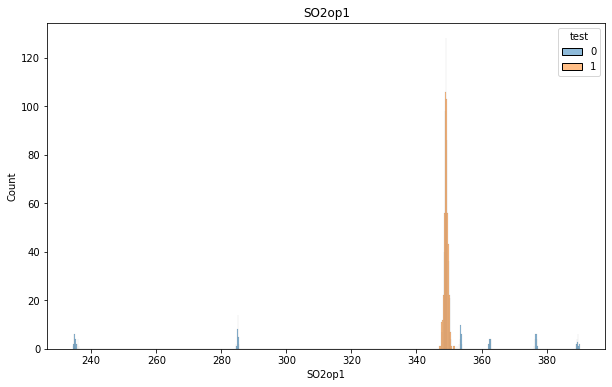

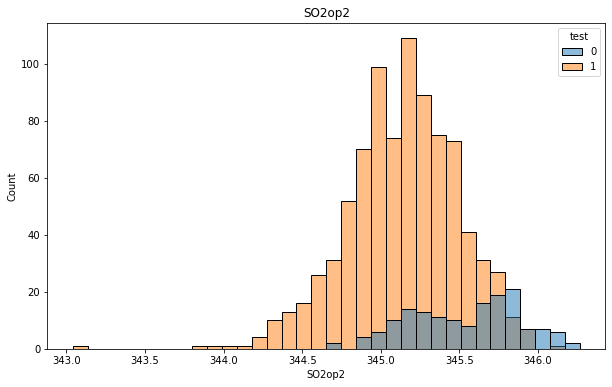

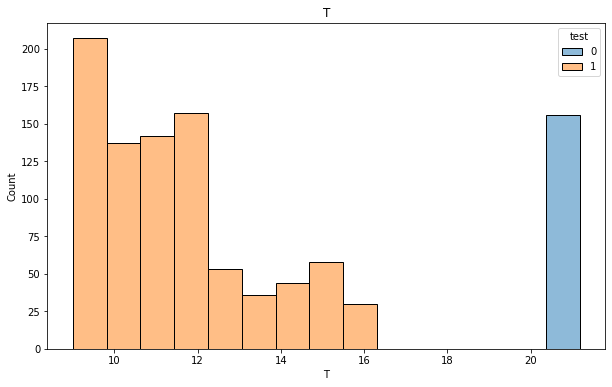

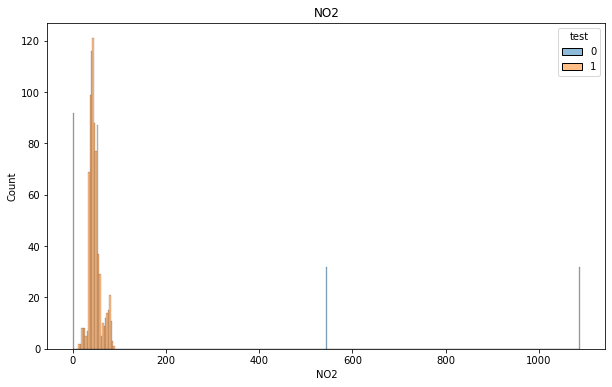

In [25]:
# Гистограммы
for col in features:  
    plt.figure(figsize=(10,6))
    sns.histplot(data = df, x = col, hue='test')
    plt.title(col)
    plt.show()

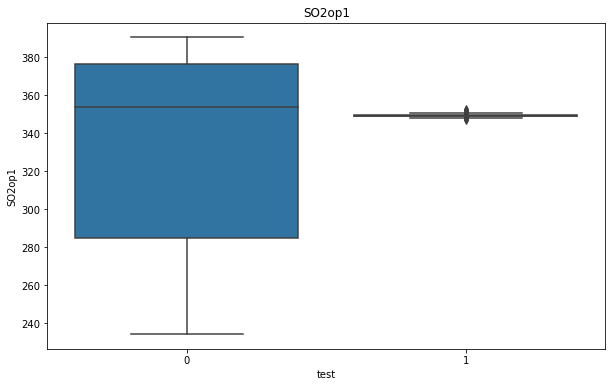

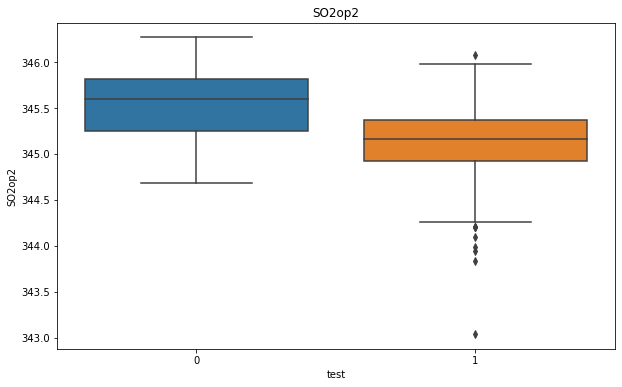

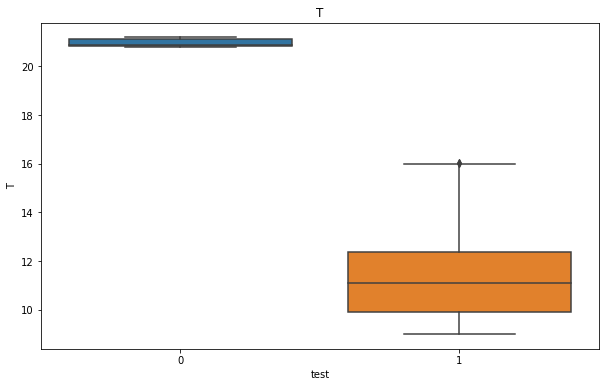

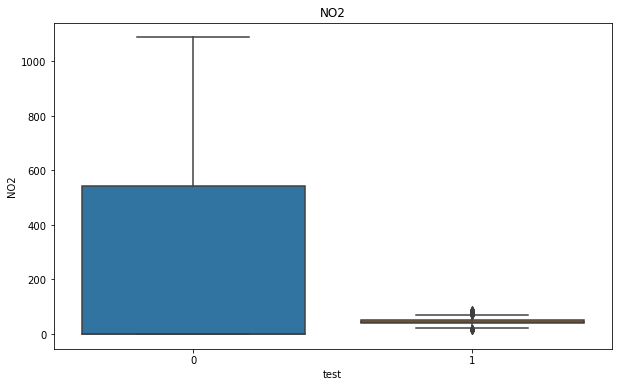

In [26]:
# Боксплоты
for col in num_cols:  
    plt.figure(figsize=(10,6))
    sns.boxplot(data = df, y = col, x ='test')
    plt.title(col)
    plt.show()

Проведём, тест Колмогорова-Смирнова, чтобы убедиться, что мы имеем существенные различия калибровочных и промысловых данных.

In [27]:
KS = np.array([])
for col in num_cols:
    KS = np.append(KS, np.round(ks_2samp(test[col], train[col])[1], 4))

In [28]:
# P-value для признаков
KS

array([0., 0., 0., 0.])

Для всех признаков p_value ~ нулю и мы можем отвергать нулевую гипотезу о том, что тестовые данные принадлежат тому же распределению, что и тренировочные.

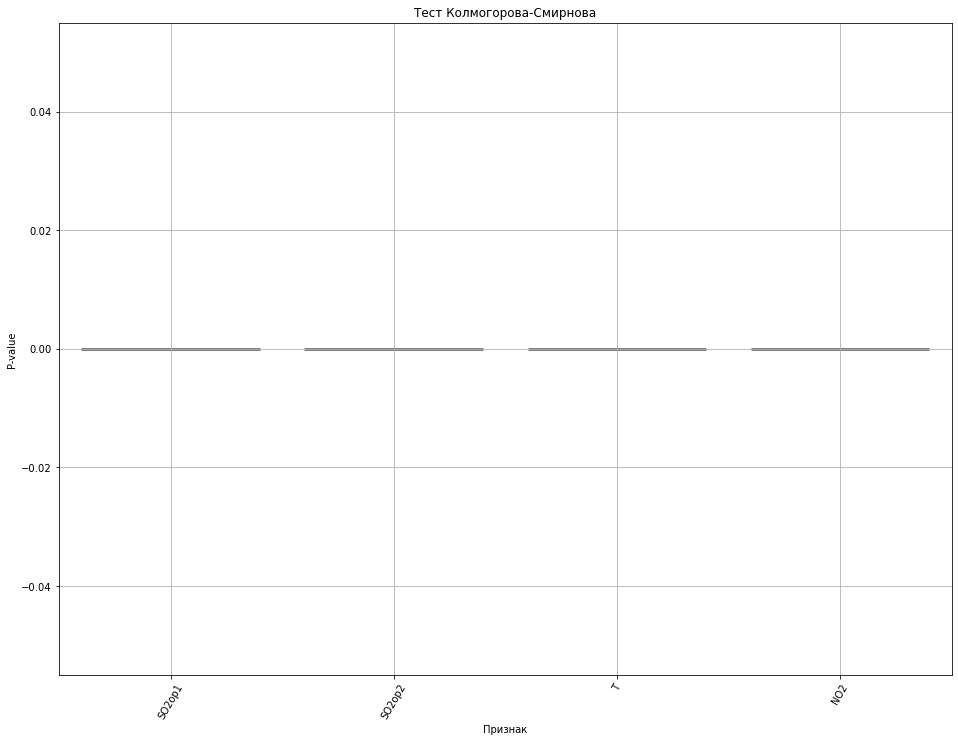

In [29]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.barplot(num_cols, KS, 
    linewidth=3, edgecolor=".5")
plt.title("Тест Колмогорова-Смирнова")
ax.set_xlabel('Признак')
ax.set_ylabel('P-value')
ax.grid(True)
plt.xticks(rotation = 60)
plt.show()

Построим график с изменением признаков в трейне во времени.

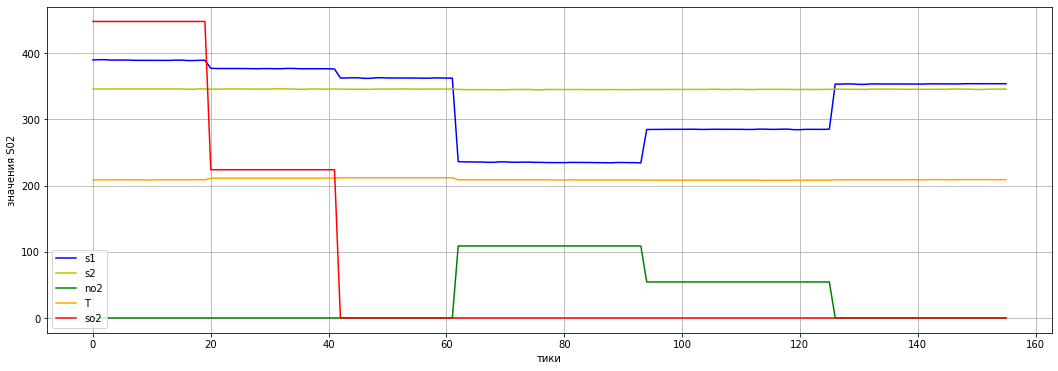

In [30]:
# мастшабируем некоторые значения

t = np.arange(len(df.loc[df['test'] == 0,'date']))
s1 = df.loc[df['test'] == 0, 'SO2op1'].values
s2 = df.loc[df['test'] == 0, 'SO2op2'].values
T = df.loc[df['test'] == 0, 'T'].values * 10
no2 = df.loc[df['test'] == 0, 'NO2'].values / 10
so2 = df.loc[df['test'] == 0, 'SO2'].values
plt.figure(figsize= (18, 6))
plt.plot(t, s1, 'b', label = 's1')
plt.plot(t, s2, 'y', label = 's2')
plt.plot(t, no2, 'g', label = 'no2')
plt.plot(t, T, 'orange', label = 'T')
plt.plot(t, so2, 'r', label = 'so2')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения S02')
plt.legend()

Теперь посмотрим на изменения с нормализация по MinMax

In [31]:
vis_df = df.copy()
scl = MinMaxScaler()
vis_df[num_cols + target] = scl.fit_transform(df[num_cols + target])

In [32]:
vis_df.head(5)

,date,SO2op1,SO2op2,T,SO2,NO2,test
0,2022-06-22 09:06:24,0.997089,0.825844,0.971815,1.0,0.0,0
1,2022-06-22 09:06:54,1.000000,0.911993,0.974359,1.0,0.0,0
2,2022-06-22 09:07:24,1.000000,0.911993,0.971815,1.0,0.0,0
3,2022-06-22 09:07:54,0.996455,0.868919,0.974359,1.0,0.0,0
4,2022-06-22 09:08:24,0.996455,0.868919,0.974359,1.0,0.0,0


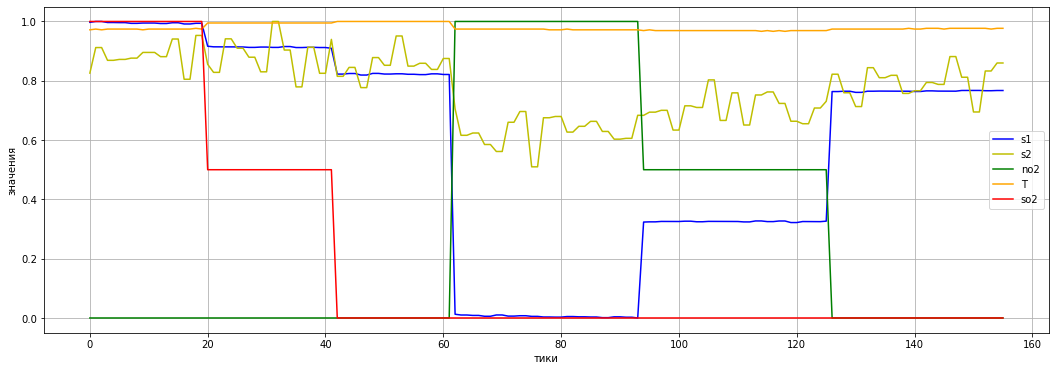

In [33]:
t = np.arange(len(vis_df.loc[vis_df['test'] == 0,'date']))
s1 = vis_df.loc[vis_df['test'] == 0, 'SO2op1'].values
s2 = vis_df.loc[vis_df['test'] == 0, 'SO2op2'].values
T = vis_df.loc[vis_df['test'] == 0, 'T'].values
no2 = vis_df.loc[vis_df['test'] == 0, 'NO2'].values
so2 = vis_df.loc[vis_df['test'] == 0, 'SO2'].values
plt.figure(figsize= (18, 6))
plt.plot(t, s1, 'b', label = 's1')
plt.plot(t, s2, 'y', label = 's2')
plt.plot(t, no2, 'g', label = 'no2')
plt.plot(t, T, 'orange', label = 'T')
plt.plot(t, so2, 'r', label = 'so2')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения')
plt.legend()

Также посмотрим на тестовую часть

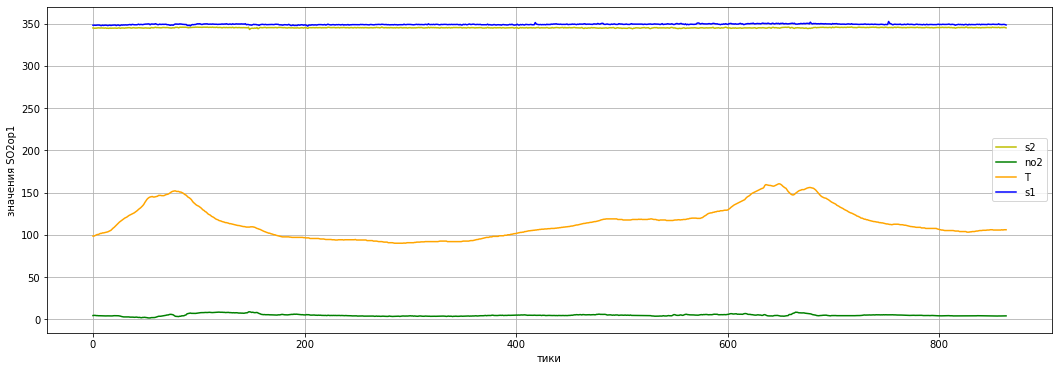

In [34]:
t = np.arange(len(df.loc[df['test'] == 1,'date']))
s1 = df.loc[df['test'] == 1, 'SO2op1'].values
s2 = df.loc[df['test'] == 1, 'SO2op2'].values
T = df.loc[df['test'] == 1, 'T'].values * 10
no2 = df.loc[df['test'] == 1, 'NO2'].values / 10
plt.figure(figsize= (18, 6))
plt.plot(t, s2, 'y', label = 's2')
plt.plot(t, no2, 'g', label = 'no2')
plt.plot(t, T, 'orange', label = 'T')
plt.plot(t, s1, 'b', label = 's1')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения SO2op1')
plt.legend()

С нормализация по MinMax

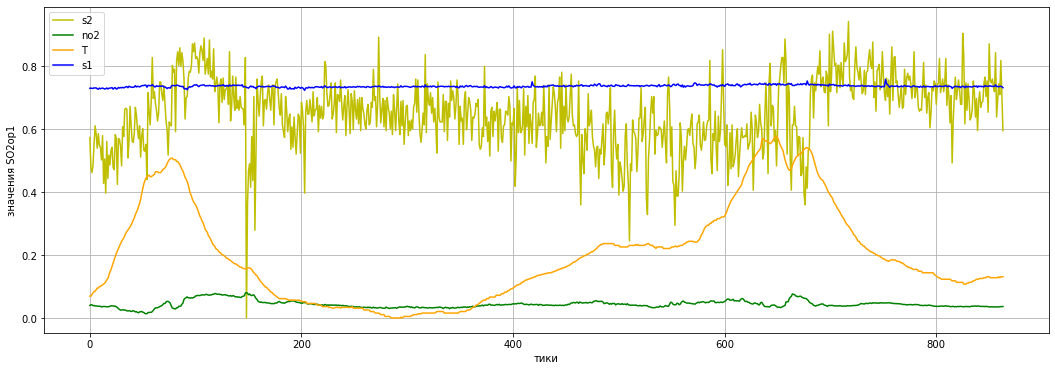

In [35]:
t = np.arange(len(vis_df.loc[vis_df['test'] == 1,'date']))
s1 = vis_df.loc[vis_df['test'] == 1, 'SO2op1'].values
s2 = vis_df.loc[vis_df['test'] == 1, 'SO2op2'].values
T = vis_df.loc[vis_df['test'] == 1, 'T'].values
no2 = vis_df.loc[vis_df['test'] == 1, 'NO2'].values
plt.figure(figsize= (18, 6))
plt.plot(t, s2, 'y', label = 's2')
plt.plot(t, no2, 'g', label = 'no2')
plt.plot(t, T, 'orange', label = 'T')
plt.plot(t, s1, 'b', label = 's1')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения SO2op1')
plt.legend()

Объеденим трейн и тест, чтобы увидеть различия.

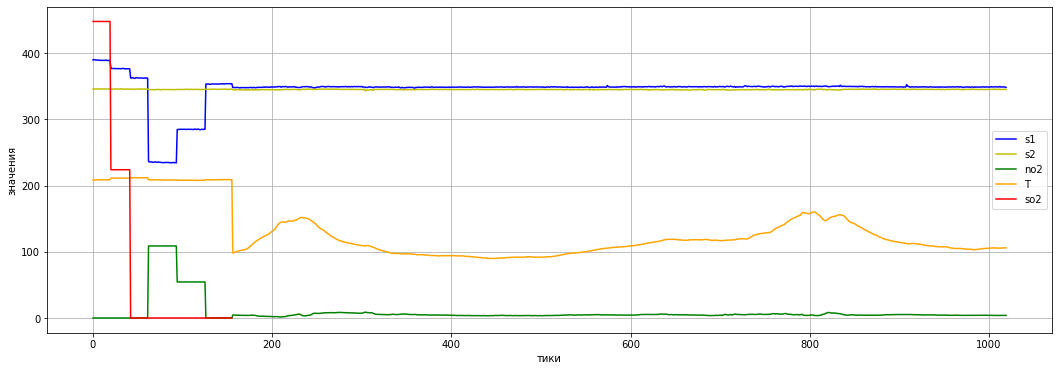

In [36]:
t = np.arange(len(df['date']))
s1 = df['SO2op1'].values
s2 = df['SO2op2'].values
T = df['T'].values * 10
no2 = df['NO2'].values / 10
so2 = df['SO2'].values
plt.figure(figsize= (18, 6))
plt.plot(t, s1, 'b', label = 's1')
plt.plot(t, s2, 'y', label = 's2')
plt.plot(t, no2, 'g', label = 'no2')
plt.plot(t, T, 'orange', label = 'T')
plt.plot(t, so2, 'r', label = 'so2')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения')
plt.legend()

C нормализацией по MinMax

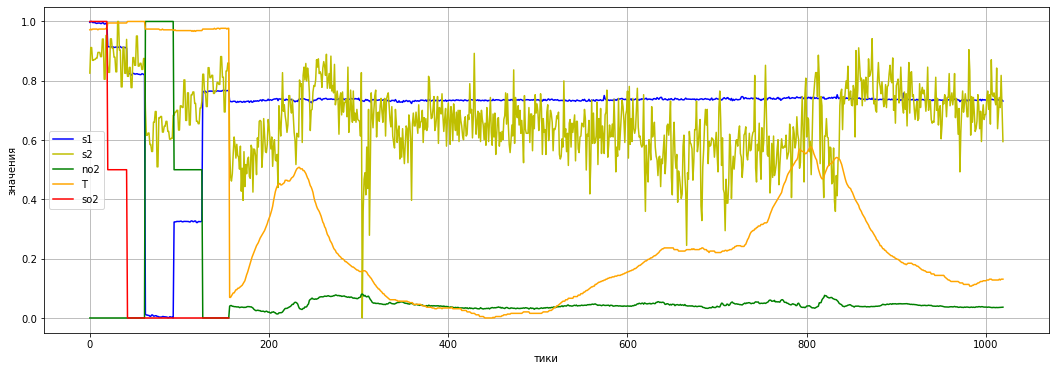

In [37]:
t = np.arange(len(vis_df['date']))
s1 = vis_df['SO2op1'].values
s2 = vis_df['SO2op2'].values
T = vis_df['T'].values
no2 = vis_df['NO2'].values
so2 = vis_df['SO2'].values
plt.figure(figsize= (18, 6))
plt.plot(t, s1, 'b', label = 's1')
plt.plot(t, s2, 'y', label = 's2')
plt.plot(t, no2, 'g', label = 'no2')
plt.plot(t, T, 'orange', label = 'T')
plt.plot(t, so2, 'r', label = 'so2')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения')
plt.legend()

Попробуем визуализировать взаимосвязь признаков между друг другом.

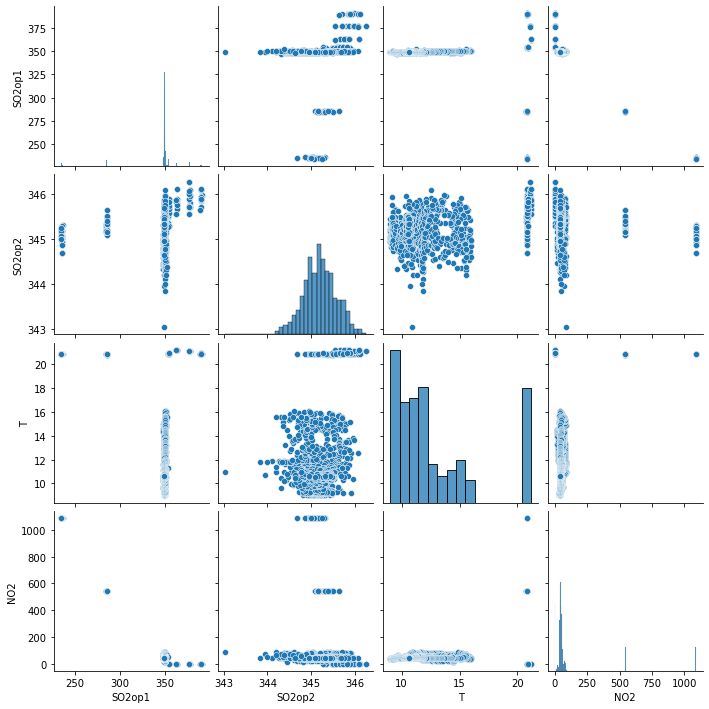

In [38]:
# для общей выборки
sns.pairplot(
    df[num_cols]
    )

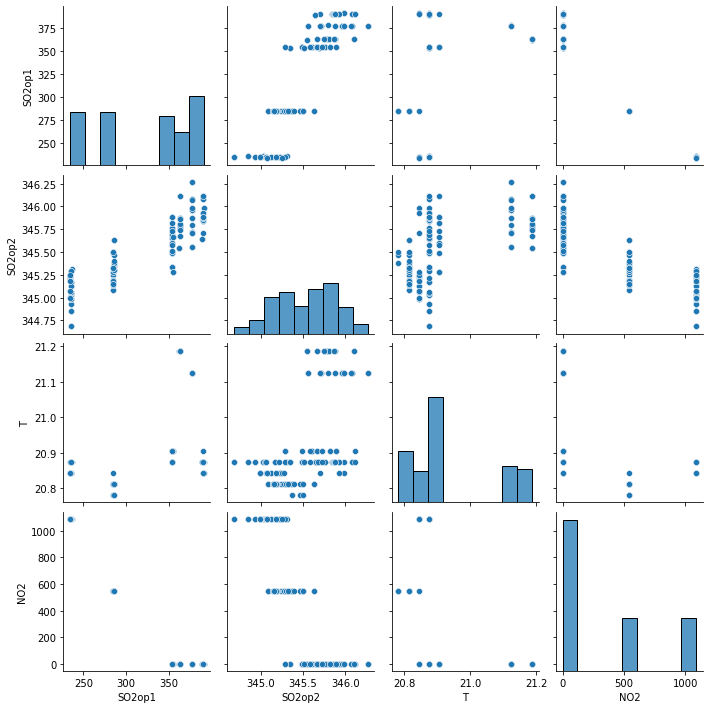

In [39]:
# для тренировочной
sns.pairplot(
    df.loc[df['test'] == 0, num_cols]
    )

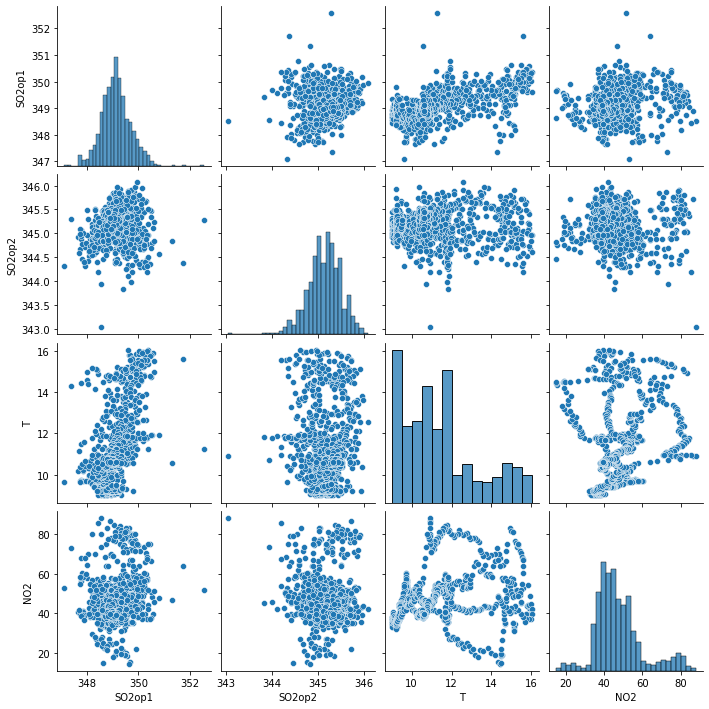

In [40]:
# для тестовой
sns.pairplot(
    df.loc[df['test'] == 1, num_cols]
    )

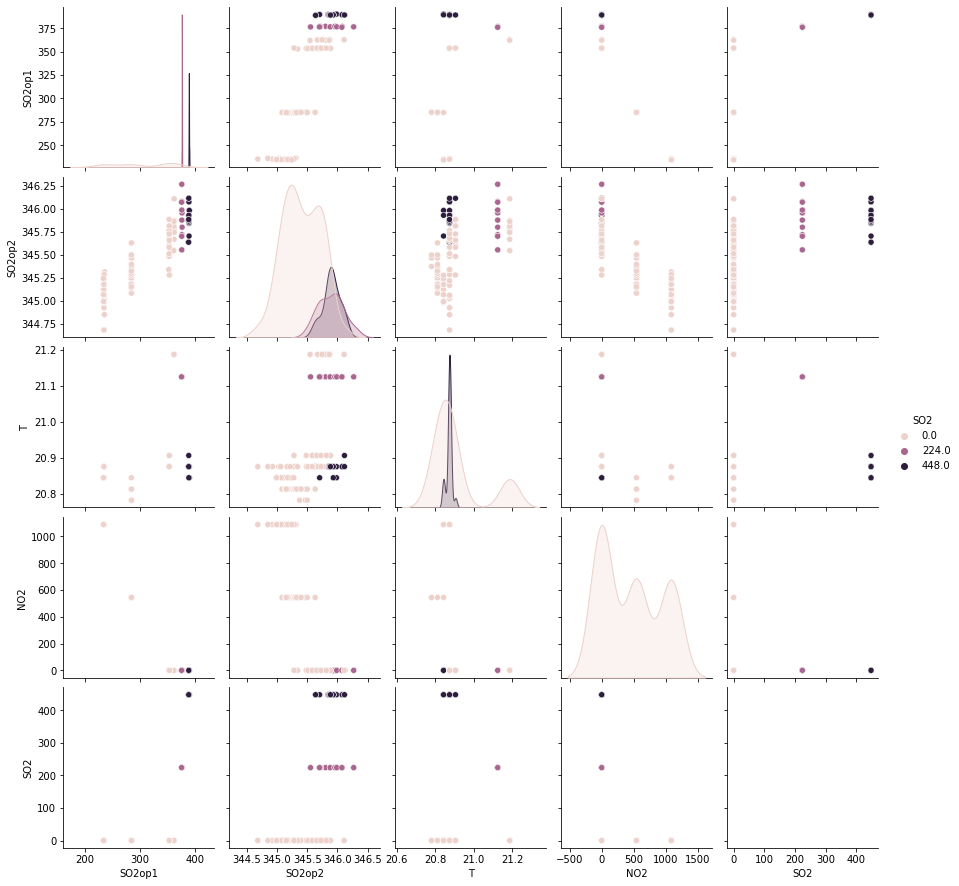

In [41]:
# добавим разделение по значению целевой переменной для тренировочной выборки
sns.pairplot(
    data = df.loc[df['test'] == 0, num_cols + ['SO2']],
    vars = num_cols + ['SO2'],
    hue = 'SO2'
    )

Посмотрим на корреляцию признаков между собой и с целевой переменной

In [42]:
df[num_cols].corr()

,SO2op1,SO2op2,T,NO2
SO2op1,1.000000,0.153345,-0.320251,-0.965426
SO2op2,0.153345,1.000000,0.339909,-0.063112
T,-0.320251,0.339909,1.000000,0.459938
NO2,-0.965426,-0.063112,0.459938,1.000000


In [43]:
df.loc[df['test'] == 0, num_cols + target].corr()

,SO2op1,SO2op2,T,NO2,SO2
SO2op1,1.000000,0.882848,0.543612,-0.975344,0.602636
SO2op2,0.882848,1.000000,0.558757,-0.843180,0.572706
T,0.543612,0.558757,1.000000,-0.518100,0.104972
NO2,-0.975344,-0.843180,-0.518100,1.000000,-0.431805
SO2,0.602636,0.572706,0.104972,-0.431805,1.000000


In [44]:
df.loc[df['test'] == 1, num_cols].corr()

,SO2op1,SO2op2,T,NO2
SO2op1,1.000000,0.084522,0.570919,0.191763
SO2op2,0.084522,1.000000,-0.004809,-0.020231
T,0.570919,-0.004809,1.000000,0.217270
NO2,0.191763,-0.020231,0.217270,1.000000


Заметим, что в тренировочной выборке корреляция NO2 с SO2op1 очень сильная, а в тестовой выборке такой зависимости нет.

Выводы

Что можно сказать об обучающей и тестовой выборках?
1. Обучающая выборка представлена наблюдениями лабораторной калибровки.   
В данных мы видим мало уникальных значений в целевом признаке S02, хотя предполагаем, что данное значение в промысловых условиях должно быть представлено в виде непрерывной числовой переменной.  
Это первое отличие обучающей выборки от реальных промысловых условий, где по моему предположению со временем целевая переменная должна изменяться непрерывно и должна иметь большое количество промежуточных значений между нулём и предельными значениями концентраций.  
2. Количество наблюдений в обучающей выборке существенно меньше количества наблюдений из тестовой выборки.
3. Распределения признаков в обучающей и тестовой выборках существенно отличаются. Мы увидели это как визуально, так и статистически. Это может привести к серьёзной ошибке на тестовой выборке.  
Например, распределения признака T (температура) из обучающей и тестовой выборки вообще не пересекаются. 
На данный момент его нельзя использовать в линейной регрессии для предсказаний из-за нехватки данных в обучающей выборке.   
В дальнейшем подтвердим это экспериментом.
4. В условиях, когда данных недостаточно и выборки сильно отличаются, использование только моделей основанных на деревьях решений (случайный лес, бустинг) может привести к серьёзным ошибкам, т.к.  
эти алгоритмы не умеют экстраполировать предсказания на новых данных.

Что увидели ещё?
1. Основной датчик SO2op1 хорошо разделяет значения целевой переменной SO2
2. Наличие газа NO2 сильно коррелирует с показаниями датчика S02op1; возможно, при обучении линейной модели его лучше исключить из обучения.
3. С учётом распределния признака T в обучающей и тестовой выборке, его нельзя использовать для обучения и предсказания линейной модели на тестовую выборку.



# Cross-validation, выбор модели, выбор метрик

На этапе кросс-валидации на текущих данных рассмотрим сравнение линейной модели и модели основанной на случайном лесе.   
Не будем рассматривать бустинг, т.к. у нас мало признаков и мало объектов, поэтому усложнение модели не потребуется.   
Т.к. формально мы имеем задачу регрессии, то в качестве метрик выберем коэффициент детерминации r2 (чем ближе к 1, тем лучшее) и среднюю квадратичную ошибку mse (чем меньше, тем лучшше).

In [45]:
random_seed = 42
# выделим признаки для обучения
fit_feats = ['SO2op1', 'SO2op2', 'T', 'NO2']

# подготовим сплиттер для 3к-кросс-валидации
cv_splitter = KFold(
    n_splits = 3,
    shuffle = True, 
    random_state = random_seed
    )

metrics = pd.DataFrame(index = ['r2', 'mse'])

## baseline LinearRegression

In [46]:
# нормализуем данные для линейной регрессии
scl = MinMaxScaler()
scl.fit(df[fit_feats])
X = scl.transform(df.loc[df['test'] == 0, fit_feats])
y = df.loc[df['test'] == 0, 'SO2']

In [47]:
# на стандартных настройках гиперпараметров
lr = LinearRegression()
metrics.loc['r2', 'lr'] = cross_val_score(lr, X, y, cv = cv_splitter, n_jobs = -1, scoring = 'r2').mean()
metrics.loc['mse', 'lr'] = np.abs(cross_val_score(lr, X, y, cv = cv_splitter, n_jobs = -1, scoring = 'neg_mean_squared_error').mean())

In [48]:
metrics

,lr
r2,0.959670
mse,997.228825


Посмотрим на коэффициенты при признаках

In [49]:
lr.fit(X, y)
imp = pd.Series(data = lr.coef_, index = fit_feats)
imp

SO2op1    1711.911016
SO2op2      77.975424
T        -5326.367558
NO2       1285.265297
dtype: float64

In [50]:
# сделаем предикт на обучающей выборке
predict_train = lr.predict(X)

<AxesSubplot:ylabel='Count'>

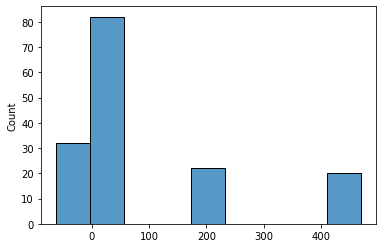

In [51]:
sns.histplot(predict_train)

<AxesSubplot:ylabel='Count'>

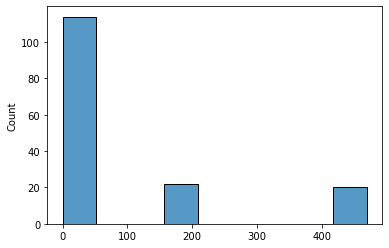

In [52]:
# предобработаем предикт, избавившись от отрицательных значений
predict_train = np.where(predict_train < 0, 0, predict_train)
sns.histplot(predict_train)

Визуализируем предикт на тренировочных данных

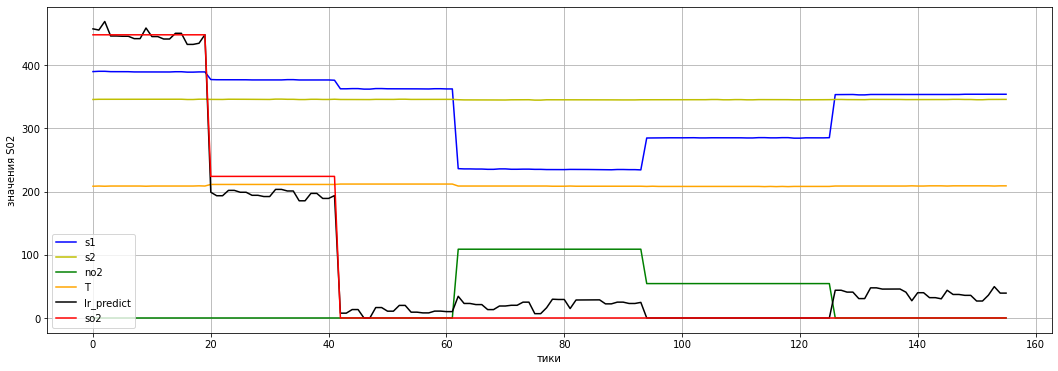

In [53]:
# мастшабируем некоторые значения

t = np.arange(len(df.loc[df['test'] == 0,'date']))
s1 = df.loc[df['test'] == 0, 'SO2op1'].values
s2 = df.loc[df['test'] == 0, 'SO2op2'].values
T = df.loc[df['test'] == 0, 'T'].values * 10
no2 = df.loc[df['test'] == 0, 'NO2'].values / 10
pred = predict_train
so2 = df.loc[df['test'] == 0, 'SO2'].values
plt.figure(figsize= (18, 6))
plt.plot(t, s1, 'b', label = 's1')
plt.plot(t, s2, 'y', label = 's2')
plt.plot(t, no2, 'g', label = 'no2')
plt.plot(t, T, 'orange', label = 'T')
plt.plot(t, pred, 'black', label = 'lr_predict')
plt.plot(t, so2, 'r', label = 'so2')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения S02')
plt.legend()

## baseline RandomForestRegression

In [54]:
# для случайного леса данные можно не нормализовывать
X = df.loc[df['test'] == 0, fit_feats]
y = df.loc[df['test'] == 0, 'SO2']

In [55]:
# на стандартных настройках гиперпараметров
rfr = RandomForestRegressor()
metrics.loc['r2', 'rfr'] = cross_val_score(rfr, X, y, cv = cv_splitter, n_jobs = -1, scoring = 'r2').mean()
metrics.loc['mse', 'rfr'] = np.abs(cross_val_score(rfr, X, y, cv = cv_splitter, n_jobs = -1, scoring = 'neg_mean_squared_error').mean())

In [56]:
metrics

,lr,rfr
r2,0.959670,1.0
mse,997.228825,0.0


Случайный лес сработал безошибочно на обучающей выборке в отличие от линейной регрессии.

Посмотрим на важность признаков

In [57]:
rfr.fit(X, y)
imp = pd.Series(data = rfr.feature_importances_, index = fit_feats)
imp

SO2op1    0.921461
SO2op2    0.000000
T         0.078539
NO2       0.000000
dtype: float64

Модель случайного леса безошибочно определяет количество SO2 на обучающей выборке только по датчику SO2op1 и температуре.

График предсказания и фактического значения будeт полностью совпадать.

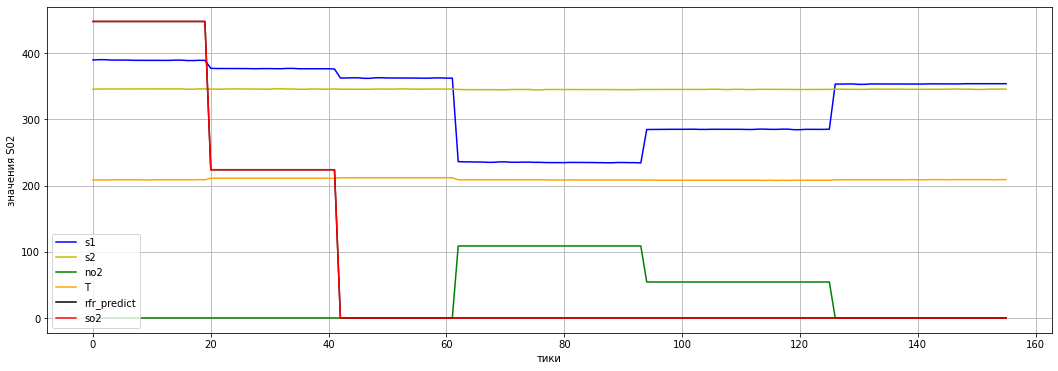

In [58]:
# построим предикт на обучающей выборке
predict_train = rfr.predict(X)

# мастшабируем некоторые значения

t = np.arange(len(df.loc[df['test'] == 0,'date']))
s1 = df.loc[df['test'] == 0, 'SO2op1'].values
s2 = df.loc[df['test'] == 0, 'SO2op2'].values
T = df.loc[df['test'] == 0, 'T'].values * 10
no2 = df.loc[df['test'] == 0, 'NO2'].values / 10
pred = predict_train
so2 = df.loc[df['test'] == 0, 'SO2'].values
plt.figure(figsize= (18, 6))
plt.plot(t, s1, 'b', label = 's1')
plt.plot(t, s2, 'y', label = 's2')
plt.plot(t, no2, 'g', label = 'no2')
plt.plot(t, T, 'orange', label = 'T')
plt.plot(t, pred, 'black', label = 'rfr_predict')
plt.plot(t, so2, 'r', label = 'so2')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения S02')
plt.legend()

# Predict

С учётом различий обучающей и тестовой выборки предлагаю посмотреть результаты  
нескольких моделей:
1. Базовой Линейной регрессии.
2. Базовой RandomForestRegressor
3. Базовой Линейной регрессии с исключёнными признаками T, NO2
4. Совмещённых моделей №2 и №3.

## 1. LinearRegression

In [59]:
# нормализуем и делим выборку на трейн и тест
scl.fit(df[fit_feats])
X_train = scl.transform(df.loc[df['test'] == 0, fit_feats])
y_train = df.loc[df['test'] == 0, 'SO2']
X_test = scl.transform(df.loc[df['test'] == 1, fit_feats])
y_test = df.loc[df['test'] == 1, 'SO2']

In [60]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

<AxesSubplot:ylabel='Count'>

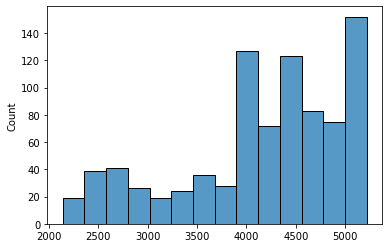

In [61]:
# распределение предсказанных значений
sns.histplot(lr_predict)

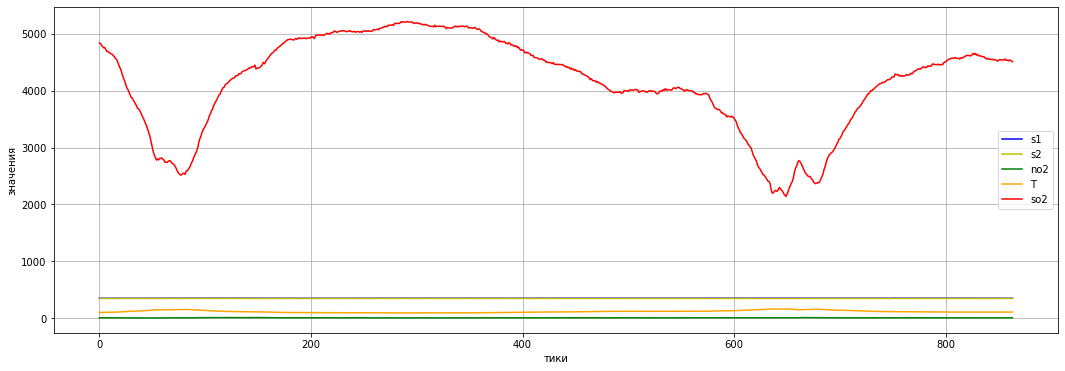

In [62]:
t = np.arange(len(df.loc[df['test'] == 1,'date']))
s1 = df.loc[df['test'] == 1, 'SO2op1'].values
s2 = df.loc[df['test'] == 1, 'SO2op2'].values
T = df.loc[df['test'] == 1, 'T'].values * 10
no2 = df.loc[df['test'] == 1, 'NO2'].values / 10
# so2 = MinMaxScaler().fit_transform(lr_predict.reshape(-1, 1))
so2 = lr_predict
plt.figure(figsize= (18, 6))
plt.plot(t, s1, 'b', label = 's1')
plt.plot(t, s2, 'y', label = 's2')
plt.plot(t, no2, 'g', label = 'no2')
plt.plot(t, T, 'orange', label = 'T')
plt.plot(t, so2, 'r', label = 'so2')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения')
plt.legend()

С нормализацией по MinMax

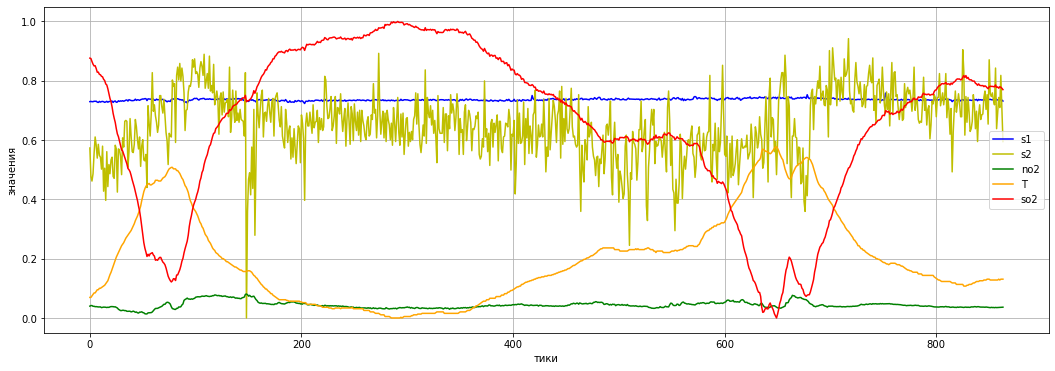

In [63]:
t = np.arange(len(vis_df.loc[vis_df['test'] == 1,'date']))
s1 = vis_df.loc[vis_df['test'] == 1, 'SO2op1'].values
s2 = vis_df.loc[vis_df['test'] == 1, 'SO2op2'].values
T = vis_df.loc[vis_df['test'] == 1, 'T'].values
no2 = vis_df.loc[vis_df['test'] == 1, 'NO2'].values
so2 = MinMaxScaler().fit_transform(lr_predict.reshape(-1, 1))
plt.figure(figsize= (18, 6))
plt.plot(t, s1, 'b', label = 's1')
plt.plot(t, s2, 'y', label = 's2')
plt.plot(t, no2, 'g', label = 'no2')
plt.plot(t, T, 'orange', label = 'T')
plt.plot(t, so2, 'r', label = 'so2')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения')
plt.legend()

Мы видим неадекватные значения SO2 доходящих до 5000мг/м3.   
Известно, что при изменении температуры различные характеристики веществ могут изменяться,   
но это не должно быть столь кардинальным, при изменении температуры до 4 градусов.  
А также видим, что температура приобрела крайне высокое влияние для тестовых данных.  
Это тот влияющий фактор, который мы подчеркнули во время разведочного анализа данных.

## 2. RandomForestRegression

In [64]:
X_train = df.loc[df['test'] == 0, fit_feats]
y_train = df.loc[df['test'] == 0, 'SO2']
X_test = df.loc[df['test'] == 1, fit_feats]
y_test = df.loc[df['test'] == 1, 'SO2']

In [65]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
rfr_predict = rfr.predict(X_test)

<AxesSubplot:ylabel='Count'>

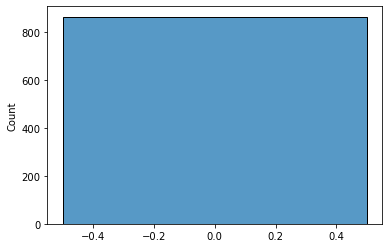

In [66]:
# распределение предсказания
sns.histplot(rfr_predict)

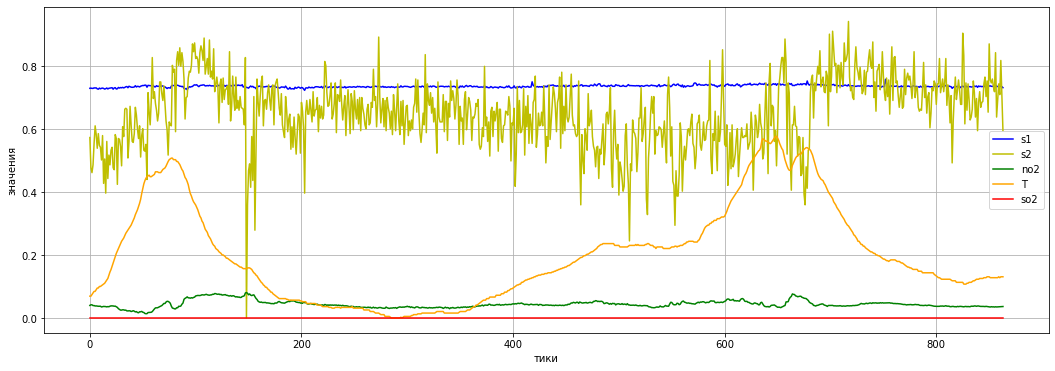

In [67]:
t = np.arange(len(vis_df.loc[vis_df['test'] == 1,'date']))
s1 = vis_df.loc[vis_df['test'] == 1, 'SO2op1'].values
s2 = vis_df.loc[vis_df['test'] == 1, 'SO2op2'].values
T = vis_df.loc[vis_df['test'] == 1, 'T'].values
no2 = vis_df.loc[vis_df['test'] == 1, 'NO2'].values
so2 = MinMaxScaler().fit_transform(rfr_predict.reshape(-1, 1))
plt.figure(figsize= (18, 6))
plt.plot(t, s1, 'b', label = 's1')
plt.plot(t, s2, 'y', label = 's2')
plt.plot(t, no2, 'g', label = 'no2')
plt.plot(t, T, 'orange', label = 'T')
plt.plot(t, so2, 'r', label = 'so2')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения')
plt.legend()

Предиктор сделал вывод о том, что значения будут равны нулю,  
т.к. он принимает решение в первую очередь на значении датчика SO2op1, который практически был неизменным,  
а также он не видел значений T ниже 20 градусов, и т.к. не умеет экстраполировать, то и не стал изменять решение.

## 3. LinearRegression2

Выкинем некоторые признаки:
- T по причине кардинально различающихся распределений в трейне и тесте
- NO2 по причине высокой корреляции с признаком S02op1 в обучающей выборке и различающейся корреляции в тестовой выборке

In [68]:
fit_feats2 = ['SO2op1', 'SO2op2']

In [69]:
# нормализуем и делим выборку на трейн и тест
scl.fit(df[fit_feats2])
X_train = scl.transform(df.loc[df['test'] == 0, fit_feats2])
y_train = df.loc[df['test'] == 0, 'SO2']
X_test = scl.transform(df.loc[df['test'] == 1, fit_feats2])
y_test = df.loc[df['test'] == 1, 'SO2']

In [70]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

<AxesSubplot:ylabel='Count'>

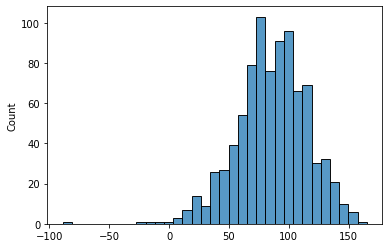

In [71]:
# распределение предсказанных значений
sns.histplot(lr_predict)

<AxesSubplot:ylabel='Count'>

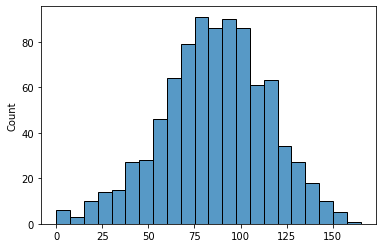

In [72]:
# пребразуем предикт
lr_predict = np.where (lr_predict < 0, 0, lr_predict)
sns.histplot(lr_predict)

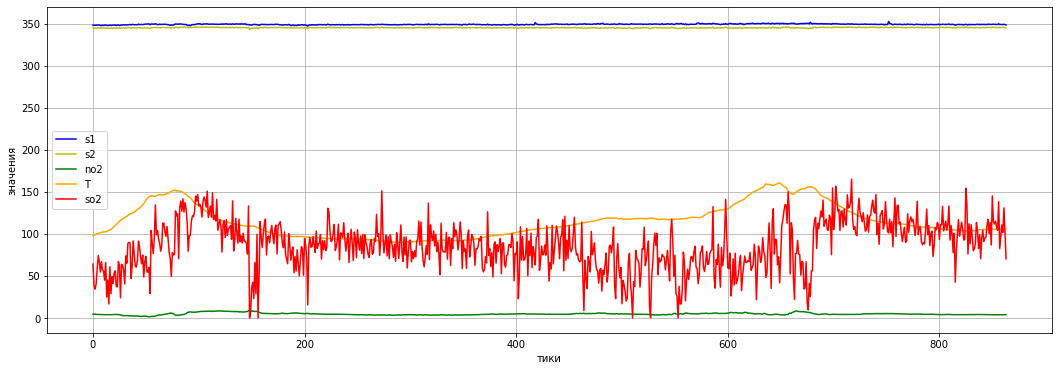

In [73]:
t = np.arange(len(df.loc[df['test'] == 1,'date']))
s1 = df.loc[df['test'] == 1, 'SO2op1'].values
s2 = df.loc[df['test'] == 1, 'SO2op2'].values
T = df.loc[df['test'] == 1, 'T'].values * 10
no2 = df.loc[df['test'] == 1, 'NO2'].values / 10
# so2 = MinMaxScaler().fit_transform(lr_predict.reshape(-1, 1))
so2 = lr_predict
plt.figure(figsize= (18, 6))
plt.plot(t, s1, 'b', label = 's1')
plt.plot(t, s2, 'y', label = 's2')
plt.plot(t, no2, 'g', label = 'no2')
plt.plot(t, T, 'orange', label = 'T')
plt.plot(t, so2, 'r', label = 'so2')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения')
plt.legend()

С нормализацией по MinMax

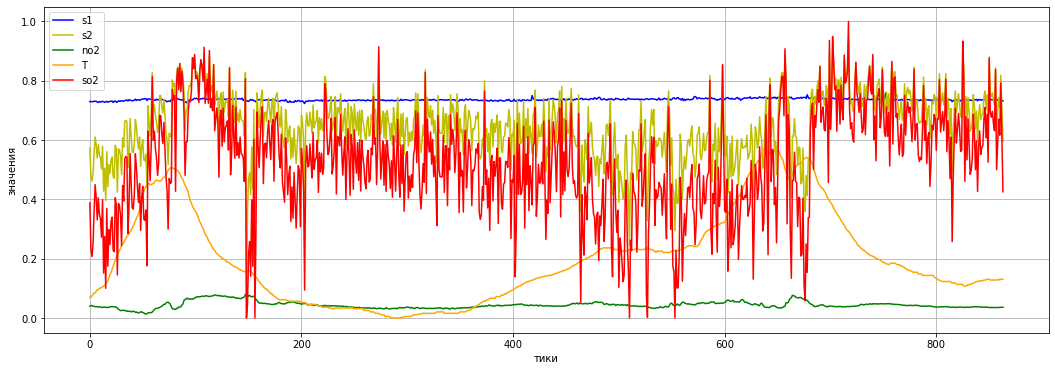

In [74]:
t = np.arange(len(vis_df.loc[vis_df['test'] == 1,'date']))
s1 = vis_df.loc[vis_df['test'] == 1, 'SO2op1'].values
s2 = vis_df.loc[vis_df['test'] == 1, 'SO2op2'].values
T = vis_df.loc[vis_df['test'] == 1, 'T'].values
no2 = vis_df.loc[vis_df['test'] == 1, 'NO2'].values
so2 = MinMaxScaler().fit_transform(lr_predict.reshape(-1, 1))
plt.figure(figsize= (18, 6))
plt.plot(t, s1, 'b', label = 's1')
plt.plot(t, s2, 'y', label = 's2')
plt.plot(t, no2, 'g', label = 'no2')
plt.plot(t, T, 'orange', label = 'T')
plt.plot(t, so2, 'r', label = 'so2')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения')
plt.legend()

In [75]:
# коэффициенты при признаках
imp = pd.Series(data = lr.coef_, index = fit_feats2)
imp

SO2op1    190.296952
SO2op2    267.910258
dtype: float64

Видим, что модель существенно улучшилась, не противоречит логике и здравому смыслу,  
а также подтверждает корреляции и взаимосвязи, которые мы отметили во время EDA:
1. Без существенных изменений значения SO2op1 предсказание также существенно не изменяется.
2. Также сохраняется логика следования за значением SO2op2, т.к. между ними также наблюдалась прямая связь, хоть и не столь сильная.  
Резкие скачки показателей датчика SO2op2 и предсказаний можно откорректировать, передавая в качестве признаков скользящее среднее или увеличив количество наблюдений в тренировочной выборке. 

## 4. RandomForestRegression + LinearRegression2

Объеденим предсказания модели основанной на RandomForestRegression и LinearRegression.  
RandomForestRegression сможет более точно указывать существенные скачки и пороги, при которых содержание SO2 будет существенно увеличиваться.  
Линейная регрессия же сможет отображать направление изменения показателя SO2, а также сможет экстрапалировать предсказание при неожиданностях в тестовых данных. 

In [76]:
blend_predict = (lr_predict + rfr_predict) / 2

<AxesSubplot:ylabel='Count'>

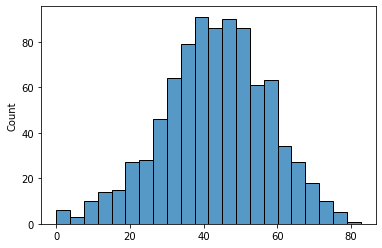

In [77]:
# распределение предсказания
sns.histplot(blend_predict)

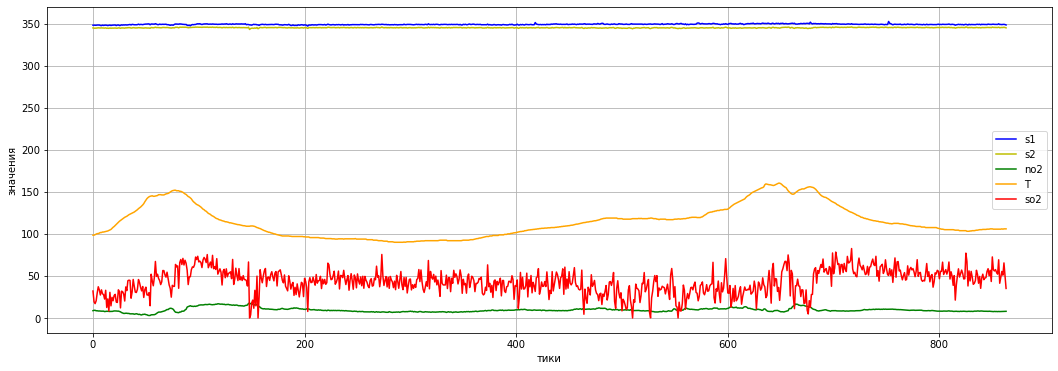

In [78]:
t = np.arange(len(df.loc[df['test'] == 1,'date']))
s1 = df.loc[df['test'] == 1, 'SO2op1'].values
s2 = df.loc[df['test'] == 1, 'SO2op2'].values
T = df.loc[df['test'] == 1, 'T'].values * 10
no2 = df.loc[df['test'] == 1, 'NO2'].values / 5
# so2 = MinMaxScaler().fit_transform(lr_predict.reshape(-1, 1))
so2 = blend_predict
plt.figure(figsize= (18, 6))
plt.plot(t, s1, 'b', label = 's1')
plt.plot(t, s2, 'y', label = 's2')
plt.plot(t, no2, 'g', label = 'no2')
plt.plot(t, T, 'orange', label = 'T')
plt.plot(t, so2, 'r', label = 'so2')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения')
plt.legend()

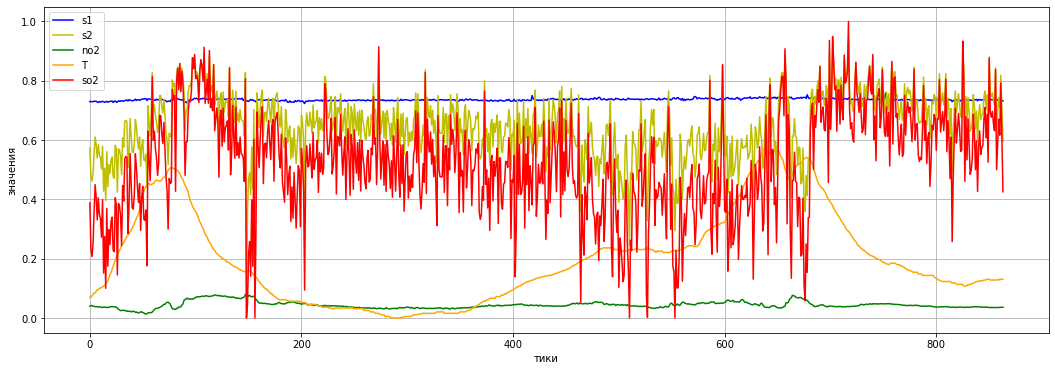

In [79]:
t = np.arange(len(vis_df.loc[vis_df['test'] == 1,'date']))
s1 = vis_df.loc[vis_df['test'] == 1, 'SO2op1'].values
s2 = vis_df.loc[vis_df['test'] == 1, 'SO2op2'].values
T = vis_df.loc[vis_df['test'] == 1, 'T'].values
no2 = vis_df.loc[vis_df['test'] == 1, 'NO2'].values
so2 = MinMaxScaler().fit_transform(blend_predict.reshape(-1, 1))
plt.figure(figsize= (18, 6))
plt.plot(t, s1, 'b', label = 's1')
plt.plot(t, s2, 'y', label = 's2')
plt.plot(t, no2, 'g', label = 'no2')
plt.plot(t, T, 'orange', label = 'T')
plt.plot(t, so2, 'r', label = 'so2')
plt.grid()
plt.xlabel('тики')
plt.ylabel('значения')
plt.legend()

# Выводы

Ход работы:

1. Прочитали файлы `G2.csv` и `test.csv`.
2. Для обучающей выборки для предсказания концентрации SO2 предложили модель RandomForestRegressor с базовыми настройками гиперпараметров.  
Для предсказаний с учётом распределения параметров в тестовой выборке предложили смешанную модель предсказания концентрации SO2: 
- RandomForestRegressor с базовыми настройками гиперпараметров с весом 0.5
- LinearRegressor с базовыми настройками гиперпараметров с весом 0.5
3. Выбрали метрики сравнения:
- коэффициент детерминации r2
- средняя квадратичная ошибка mse  
Сравнили прогнозы моделей на 3Кфолд-кросс-валидации:  
-RandomForestRegressor показывает лучшие результаты в сравнении с линейной регрессией:  
r2: 1.0 (лучше) против 0.96  
mse: 0.0 (лучше) против 997.23  
4. Построили графики прогнозов моделей на обучающей и тестовой выборках.
5. Предложили дополнительное смешанное решение c изменением количества параметров для линейной регрессии.
- Линейная регрессия учитывает изменения в датчиках SO2op1 и SO2op2, она позволяет экстраполировать предсказание при неожиданных значениях в тестовой выборке и позволяет увидеть небольшие изменения концентрации SO2
- Случайный лес более точно вычисляет пороговые значения описанные в обучающей выборке (0, 224, 448) по параметрам SO2op1 и T (в диапазоне изменений обучающей выборки)
6. В ходе работы ответили на дополнительные вопросы:
- Описали различия выборок.
- Оценили погрешность линейной модели и случайного леса. 
- Описали различия линейной модели и случайного леса